In [1]:
#Исследование математической модели, Панкратов Александр, МТ-402

from IPython.display import display
from ipywidgets import *
from IPython.display import Image
from matplotlib import pyplot as plt
import math
import random
import subprocess
from ctypes import *

lib = '/home/kokamido/Рабочий стол/диплом/ipython/cfunc.so'
cfunc = cdll.LoadLibrary(lib)

cfunc.draw_noisy_curve.restype= POINTER(POINTER(c_longdouble))
cfunc.draw_noisy_curve.argtype = [c_longdouble, c_longdouble, c_longdouble, c_longdouble,
                                  c_longdouble, c_longdouble, c_int]

cfunc.draw_curve.restype= POINTER(POINTER(c_longdouble))
cfunc.draw_curve.argtype = [c_longdouble, c_longdouble, c_longdouble, c_longdouble, c_longdouble, c_int]

p=1
q=1
Step = 0.0001
noise_lvl = 0.00001
singular_point_x = 1
singular_point_y = 1

def curve(x0,y0,n):
    res_x = list()
    res_y = list()
    bufferVals = POINTER(POINTER(c_longdouble))
    bufferVals = cfunc.draw_curve(c_longdouble(Step),
                                        c_longdouble(p),c_longdouble(q),
                                        c_longdouble(x0),c_longdouble(y0),
                                        c_int(n))
    for i in range(0,n):
        res_x.append(bufferVals[0][i])
        res_y.append(bufferVals[1][i])
    cfunc.free_crv_memory()
    return[res_x,res_y]

def curves_circle(num, r,rk_iter, color='c',lw=1):
    for i in range(1,num):
        current_curve = curve(1+r*math.cos(2*math.pi/num*i),1+r*math.sin(2*math.pi/num*i),rk_iter)
        plt.plot(current_curve[0],current_curve[1],color,linewidth=lw)

def euclidean_range(x0,y0,x1,y1):
    return math.sqrt(math.pow(x0-x1,2)+math.pow(y0-y1,2))

import random
import math
random.seed()
def normal_dist_random_values():
    x = random.random()
    y = random.random()
    
    a = math.sqrt(-2*math.log(x))*math.cos(2*math.pi*y)
    b = math.sqrt(-2*math.log(x))*math.sin(2*math.pi*y)
    return [a,b]
noise_lvl = 0.01

def noisy_curve(x0,y0,n):
    res_x = list()
    res_y = list()
    bufferVals = POINTER(POINTER(c_longdouble))
    bufferVals = cfunc.draw_noisy_curve(c_longdouble(noise_lvl),c_longdouble(Step),
                                        c_longdouble(p),c_longdouble(q),
                                        c_longdouble(x0),c_longdouble(y0),
                                        c_int(n))
    for i in range(0,n):
        res_x.append(bufferVals[0][i])
        res_y.append(bufferVals[1][i])
    cfunc.free_crv_memory()
    return[res_x,res_y]

def avg(list_arg):
    return sum(list_arg)/len(list_arg)

def expectancy(crv):
    return [avg(crv[0]),avg(crv[1])]

from functools import reduce
def dispersion(crv):
    exp = expectancy(crv)
    centr_curve = [map(lambda x: x-exp[0],crv[0]), map(lambda x: x-exp[1],crv[1])]
    return [reduce(lambda y,x: x*x+y,centr_curve[0])/len(crv[0]),reduce(lambda y,x: x*x+y,centr_curve[1])/len(crv[0])]

def time_row(vals):
    times = [i*Step for i in range(0,len(vals))]
    plt.plot(times,vals)
def cut_extreme_spikes(crv, top=200):
    x = list()
    y = list()
    count = 0
    inside_extreme_spike = False
    for i in range(0, len(crv[0])):
        if(crv[0][i]<top):
            x.append(crv[0][i])
            y.append(crv[1][i])
        if(crv[0][i]>top and not inside_extreme_spike):
            count+=1
            inside_extreme_spike = True
        
        if inside_extreme_spike and crv[0][i]<=top:
            inside_extreme_spike = False
    return {"curve" : [x,y], "extreme_spikes_count" : count}
def spikes_stat(crv, big=60,small=5):
    big_spikes_count = 0
    all_spikes_count = 0
    inside_big_spike = False
    inside_spike = False
    for i in range(0, len(crv[0])):
        if(crv[0][i]>big and not inside_big_spike):
            inside_big_spike = True
            big_spikes_count+=1
            
        if inside_big_spike and crv[0][i]<=big:
            inside_big_spike = False
            
        if(crv[0][i]>=small and not inside_spike):
            inside_spike = True
            all_spikes_count+=1
        if inside_spike and crv[0][i]<small :
                inside_spike = False
            
    return {"big" : round(big_spikes_count), "small" : round(all_spikes_count - big_spikes_count)}
def get_D_matrix(crv,e=1):
    d11 = sum(map(lambda x: (x-1)*(x-1),crv[0]))/len(crv[0])/e/e
    d22 = sum(map(lambda x: (x-1)*(x-1),crv[1]))/len(crv[1])/e/e
    d12 = sum(map(lambda x,y: (x-1)*(y-1),crv[0],crv[1]))/len(crv[0])/e/e
    return([[d11,d12],[d12,d22]])
def get_W_matrix():
    w11 = (-p*p-p*q*q-p*q-q*q-2*q-1)/(2*q*p*(p-q-1))
    w12=w21=(p*p*q+p*p+q*q+2*q+1)/(2*q*p*(p-q-1))
    w22=-((q+1)*(p*p*q+p*p+p*q+q+1))/(2*q*p*(p-q-1))
    return[[w11,w12],[w21,w22]]

#plot settings
singular_point_x = 1
singular_point_y = 1
left_bound = singular_point_x-1.5
right_bound = singular_point_x+2.5
top_bound = singular_point_y-1
bottom_bound = singular_point_x+3
#
#plt.xlim(left_bound, right_bound)
#plt.ylim(bottom_bound,top_bound)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=10
fig_size[1]=10
#

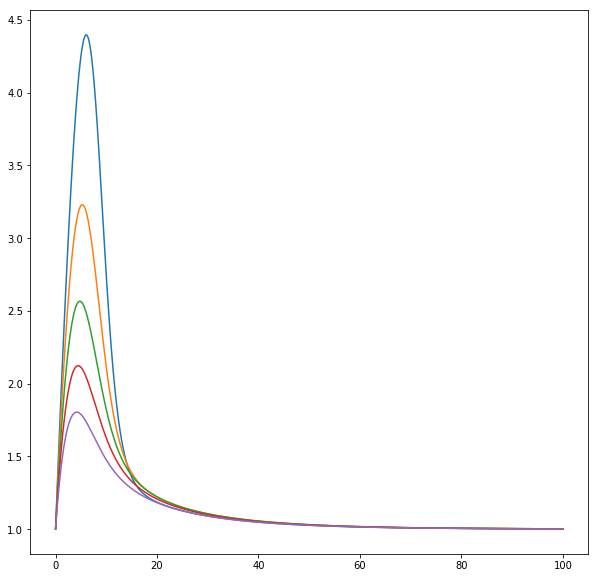

In [9]:
buf = p
p = 0.1
Step = 0.001
#curves_y(0.985, 0.995, 0.99, 0.005, 4000,color='m', lw=1)
#curves_y(1.01, 1.02, 1.01, 0.005, 10000)
for i in range(0,5):    
    x_values = curve(1,0.1+0.1*i,100000)[0]
    time_row(x_values)
p = buf
plt.show()

In [10]:
buf = p
p = 2.1
noise_lvl = 0.002
Step = 0.005
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=20
fig_size[1]=10
big_to_all_ratio = list()
for j in range(1,13):
    q = j*0.01
    crv = noisy_curve(1,0.801,10000000)
    crv = cut_extreme_spikes(crv)
    stat = spikes_stat(crv["curve"])
    big_to_all_ratio.append((stat['big'] if stat['small'] != 0 else 0)/(stat['big']+stat['small']))
    time_row(crv["curve"][0])
    plt.show()
plt.plot([z*0.01 for z in range(1,13)],big_to_all_ratio)
plt.show()
p = buf
plt.show()
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=10
fig_size[1]=10

KeyboardInterrupt: 

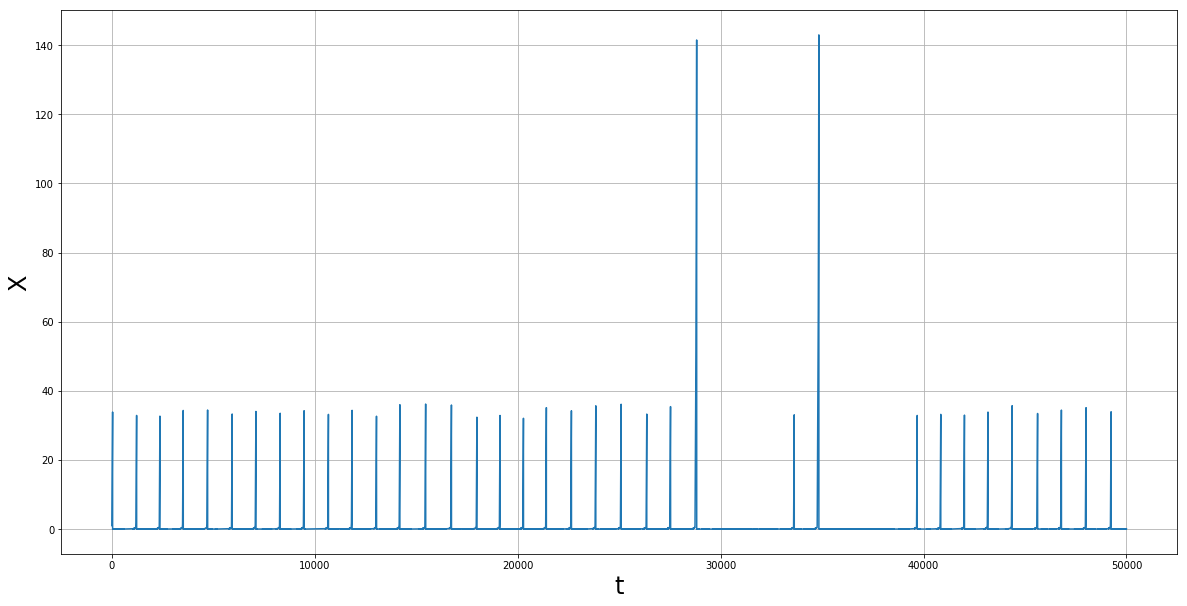

In [18]:
noise_lvl = 0.002
Step = 0.005
p=2.1
q = 0.03
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=20
fig_size[1]=10
time_row(noisy_curve(1,0.801,10000000)[0])
plt.grid()
plt.xlabel('t',fontsize=24)
plt.ylabel('X',fontsize=24)
plt.show()

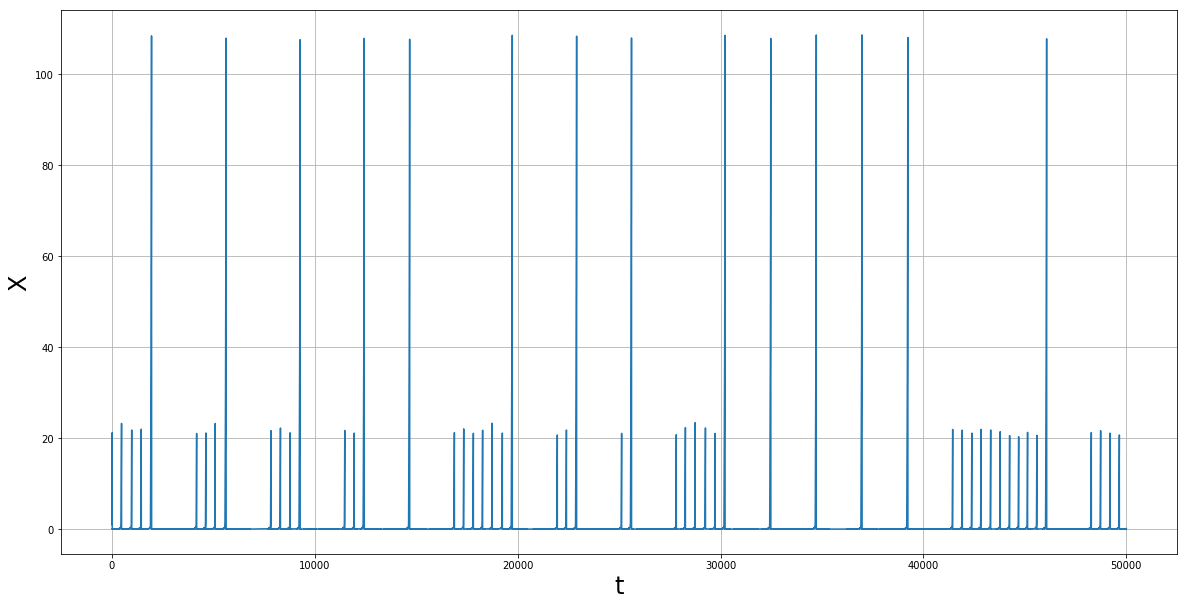

In [19]:
noise_lvl = 0.002
Step = 0.005
p=2.1
q = 0.05
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=20
fig_size[1]=10
time_row(noisy_curve(1,0.801,10000000)[0])
plt.grid()
plt.xlabel('t',fontsize=24)
plt.ylabel('X',fontsize=24)
plt.show()

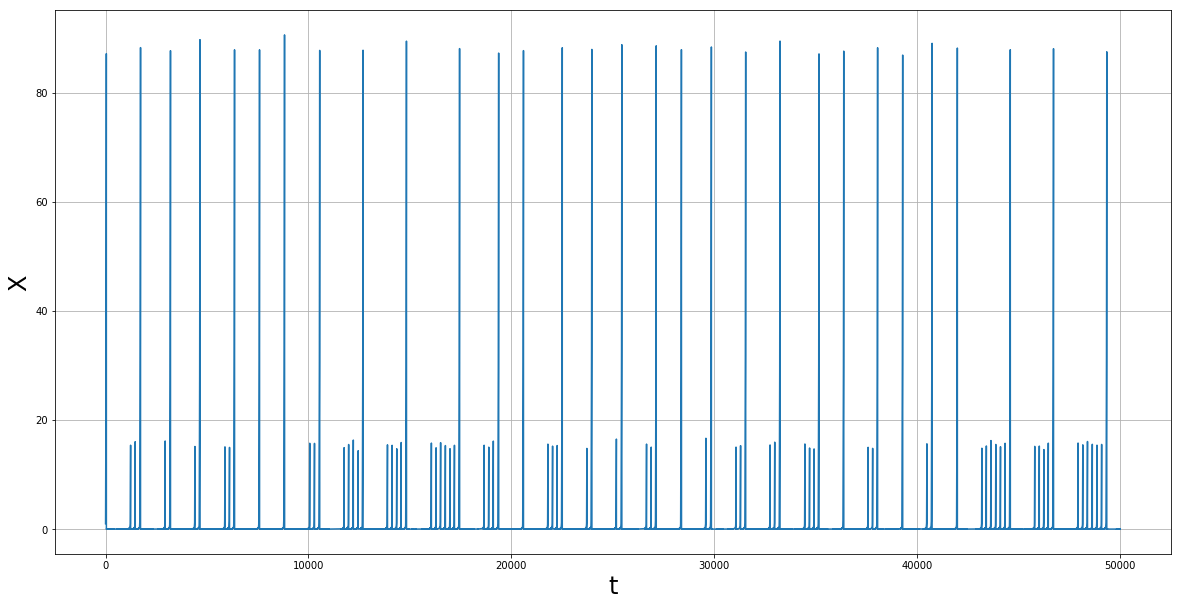

In [20]:
noise_lvl = 0.002
Step = 0.005
p=2.1
q = 0.075
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=20
fig_size[1]=10
time_row(noisy_curve(1,0.801,10000000)[0])
plt.grid()
plt.xlabel('t',fontsize=24)
plt.ylabel('X',fontsize=24)
plt.show()

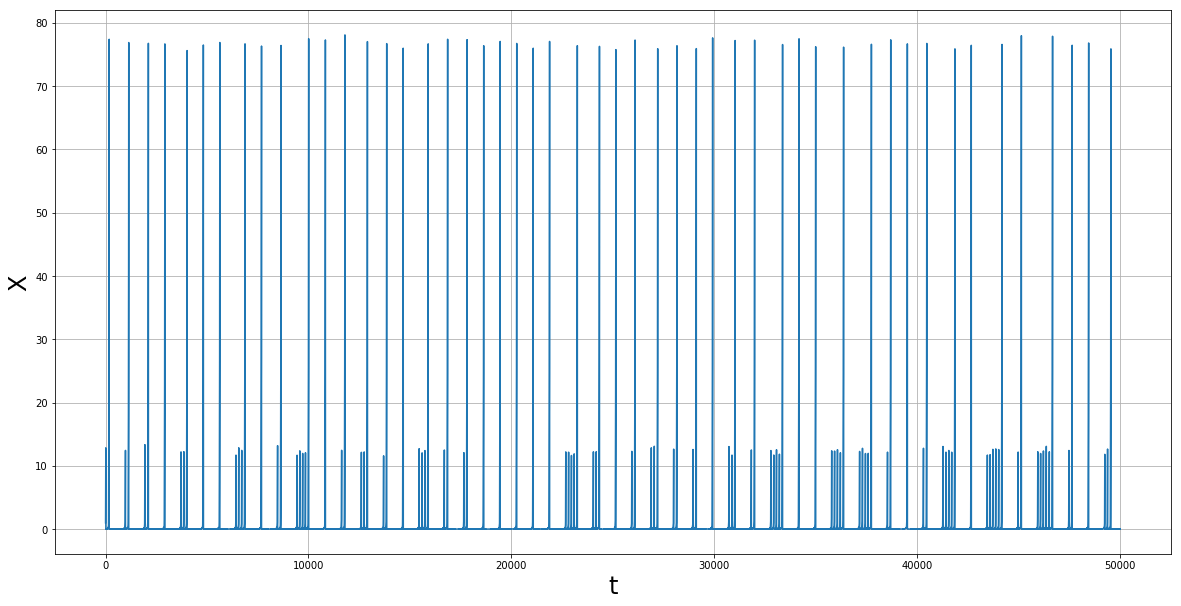

In [21]:
noise_lvl = 0.002
Step = 0.005
p=2.1
q = 0.1
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=20
fig_size[1]=10
time_row(noisy_curve(1,0.801,10000000)[0])
plt.grid()
plt.xlabel('t',fontsize=24)
plt.ylabel('X',fontsize=24)
plt.show()

Progress 0.8333333333333334%

Progress 1.6666666666666667%

Progress 2.5%

Progress 3.3333333333333335%

Progress 4.166666666666667%

Progress 5.0%

Progress 5.833333333333333%

Progress 6.666666666666667%

Progress 7.5%

Progress 8.333333333333334%

Progress 9.166666666666666%

Progress 10.0%

Progress 10.833333333333332%

Progress 11.666666666666666%

Progress 12.5%

Progress 13.333333333333334%

Progress 14.166666666666666%

Progress 15.0%

Progress 15.833333333333332%

Progress 16.666666666666668%

Progress 17.5%

Progress 18.333333333333332%

Progress 19.166666666666668%

Progress 20.0%

Progress 20.833333333333336%

Progress 21.666666666666664%

Progress 22.5%

Progress 23.333333333333332%

Progress 24.166666666666664%

Progress 25.0%

Progress 25.833333333333336%

Progress 26.666666666666668%

Progress 27.500000000000004%

Progress 28.333333333333332%

Progress 29.166666666666664%

Progress 30.0%

Progress 30.833333333333336%

Progress 31.666666666666664%

Progress 32.5%

Progre

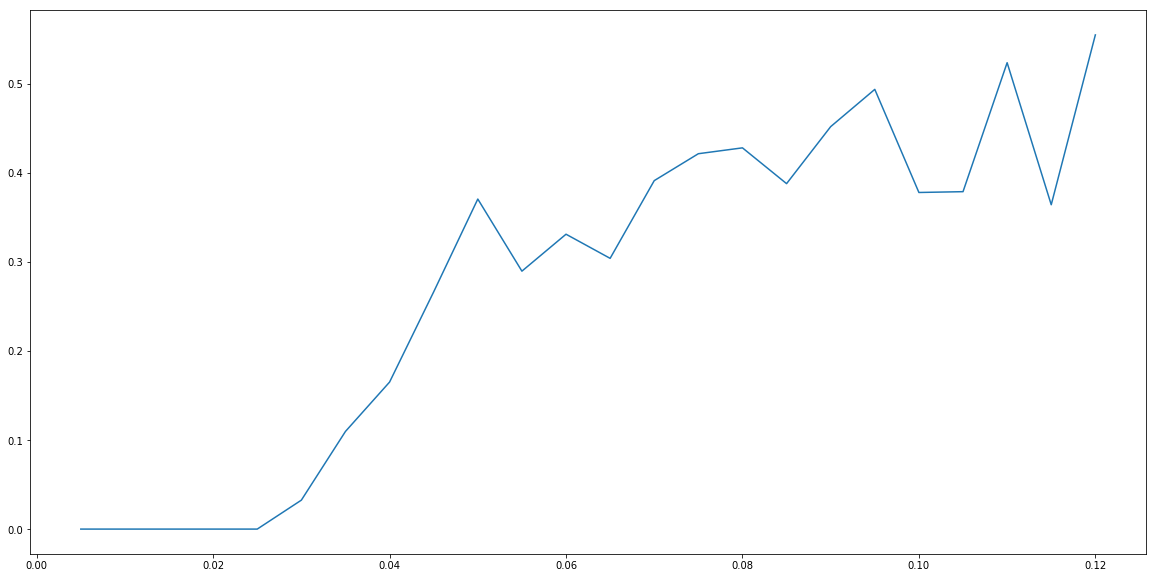

In [16]:
buf = p
p = 2.1
noise_lvl = 0.002
Step = 0.001
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=20
fig_size[1]=10
big_to_all_ratio = list()
for j in range(1,25):
    q = j*0.005
    avg = list()
    for i in range(1,6):
        crv = noisy_curve(1,0.801,20000000)
        crv = cut_extreme_spikes(crv)
        stat = spikes_stat(crv["curve"])
        crv=1
        avg.append((stat['big'] if stat['small'] != 0 else 0)/(stat['big']+stat['small']))
        print("Progress "+str(((j-1)*5+i)/24/5*100)+"%\n")
    big_to_all_ratio.append(sum(avg)/len(avg))
    #print("Progress "+str(j*100/24)+"%\n")
plt.plot([z*0.005 for z in range(1,25)],big_to_all_ratio)
plt.show()
p = buf
plt.show()
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=10
fig_size[1]=10

i am alive

Progress 8.333333333333332%

Progress 16.666666666666664%

Progress 25.0%

Progress 33.33333333333333%

Progress 41.66666666666667%

Progress 50.0%

Progress 58.333333333333336%

Progress 66.66666666666666%

Progress 75.0%

Progress 83.33333333333334%

Progress 91.66666666666666%

Progress 100.0%



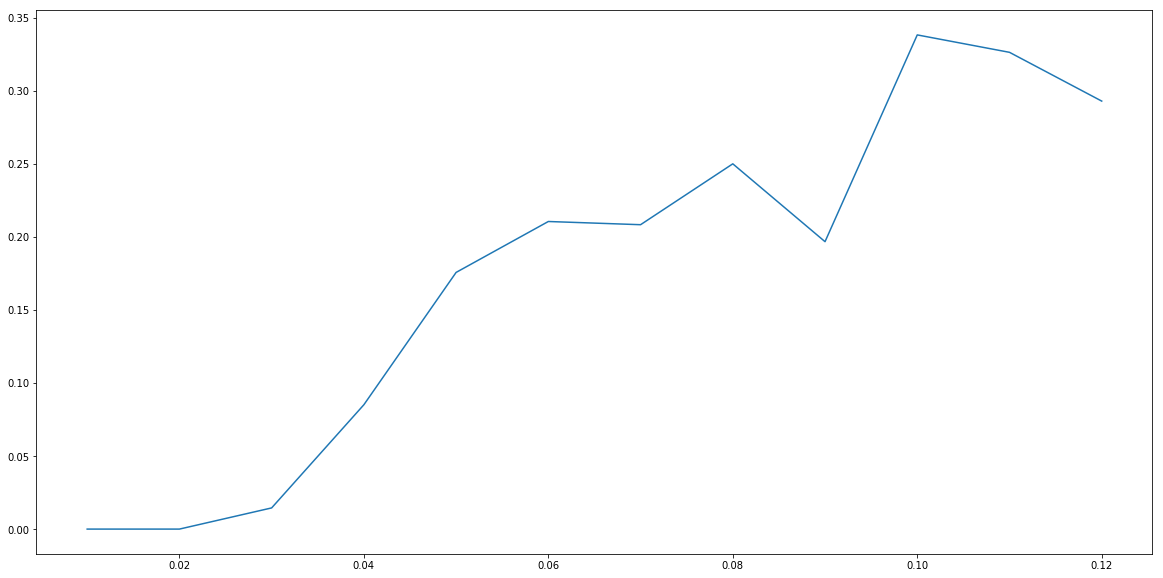

In [11]:
buf = p
p = 2.1
noise_lvl = 0.002
Step = 0.00015
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=20
fig_size[1]=10
big_to_all_ratio = list()
print('i am alive\n')
for j in range(1,13):
    q = j*0.01
    big = 0
    aall = 0
    for i in range(1,21):
        crv = noisy_curve(1,0.801,30000000)
        crv = cut_extreme_spikes(crv)
        stat = spikes_stat(crv["curve"])
        crv=1
        big+=stat['big'] if stat['small'] != 0 else 0
        aall+=stat['big']+stat['small']
    big_to_all_ratio.append(big/aall)
    print("Progress "+str(j/12*100)+"%\n")
plt.plot([z*0.01 for z in range(1,13)],big_to_all_ratio)
plt.show()
p = buf
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=10
fig_size[1]=10

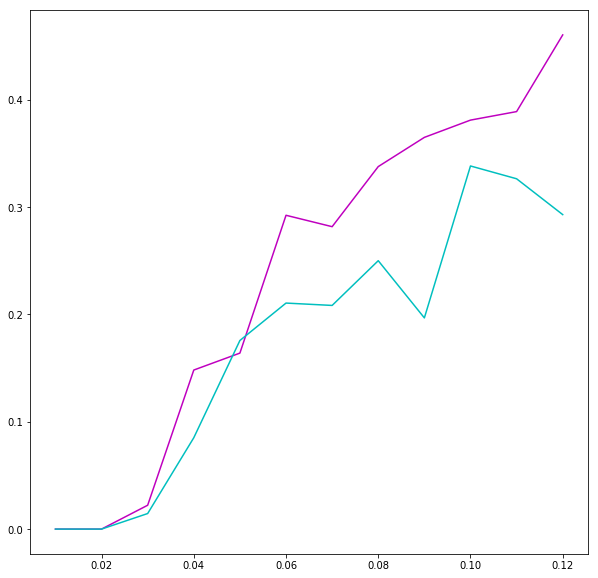

In [16]:
f = open('10ratio.txt','r')
v = open('big_to_all_ratio.txt','r')
l10 = list()
l5 = list()
qs = list()
for i in range(1,13):
    l10.append(float(f.readline().split(" ")[4]))
    l5.append(float(v.readline().split(" ")[5]))
    qs.append(0.01*i)
f.close()
v.close()
plt.plot(qs,l5,c='m')
plt.plot(qs,l10,c='c')
plt.show()

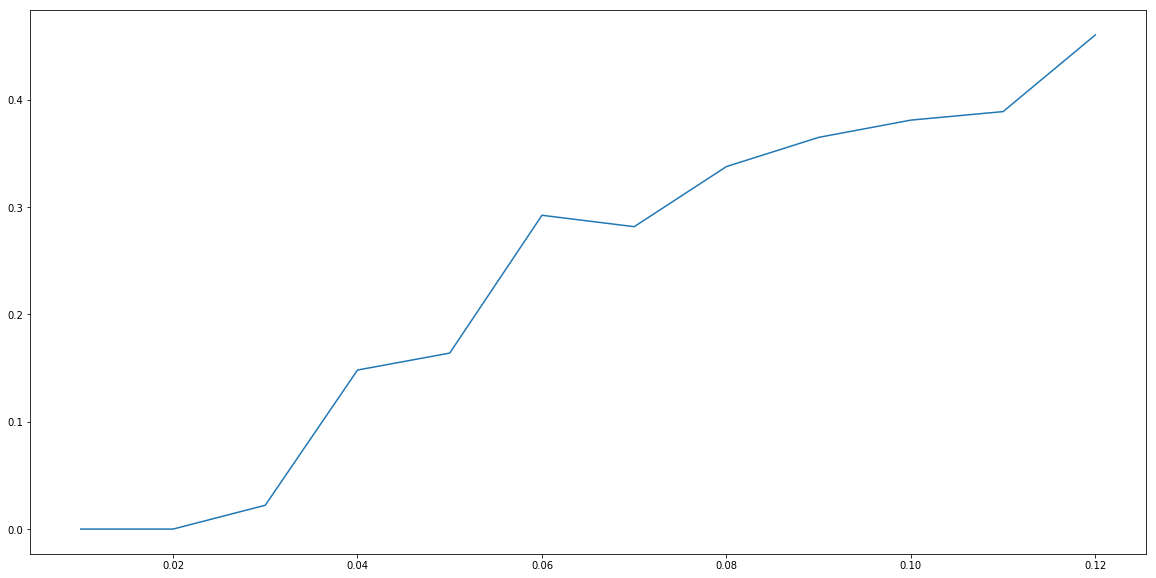

In [12]:
#new, 1st try
plt.plot([z*0.01 for z in range(1,13)],big_to_all_ratio)
plt.show()

q = 0.06; Step = 0.005; Noise ~ 0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002


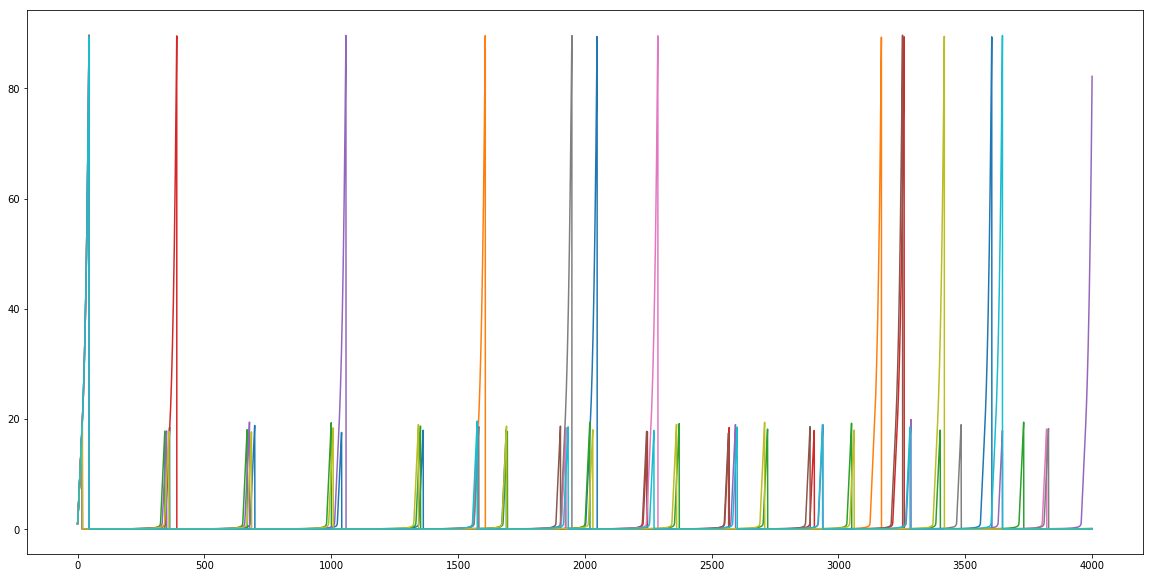

q = 0.09; Step = 0.005; Noise ~ 0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002


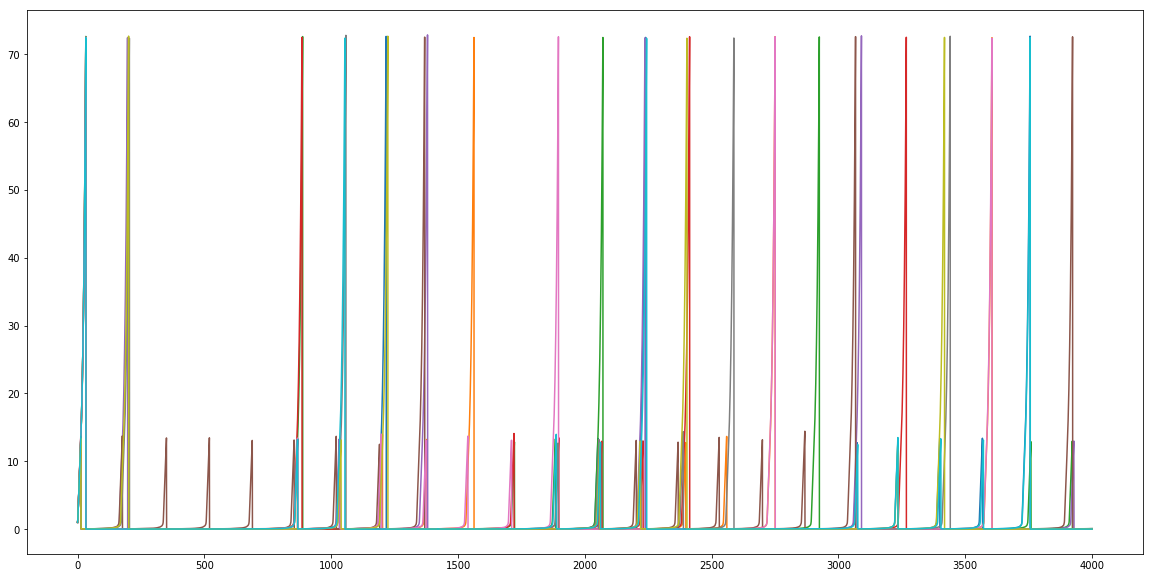

q = 0.12; Step = 0.005; Noise ~ 0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002


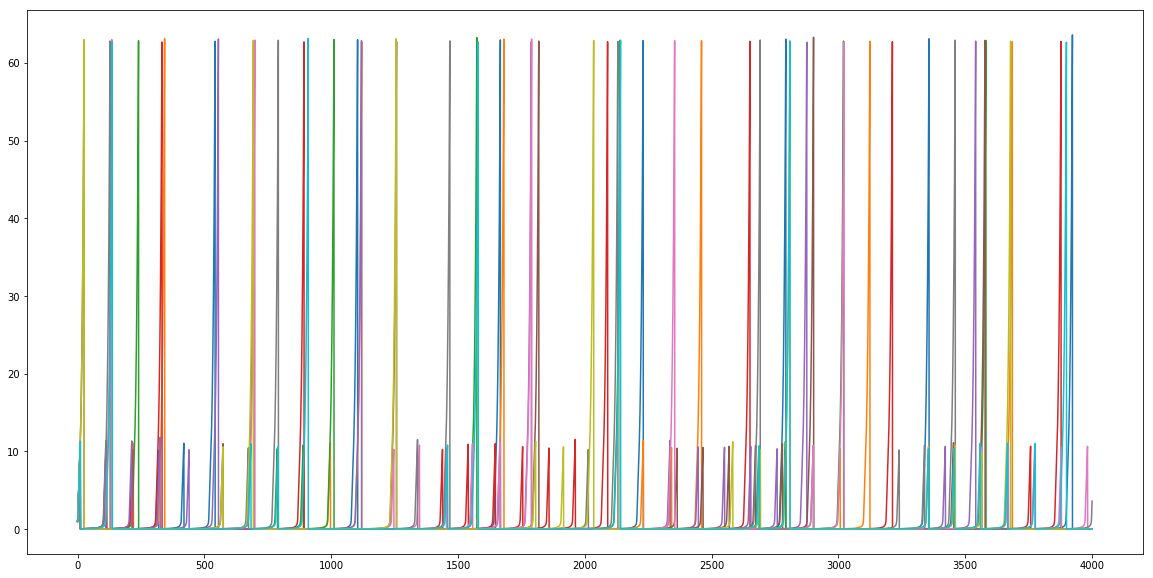

In [28]:
buf = p
p = 2.1
noise_lvl = 0.002
Step = 0.005
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=20
fig_size[1]=10
for j in range(2,5):
    q = j*0.03
    for i in range(0,1):    
        print("q = "+str(q)+ "; Step = "+str(Step)+"; Noise ~ "+str(noise_lvl))
        for k in range(0,10):
            crv = noisy_curve(1,0.801,800000)
            time_row(crv[0])
        plt.show()
p = buf
plt.show()
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=10
fig_size[1]=10

Singular point is: [1, 1].
Expectance is [0.998320529064499, 1.0428493314266416]
Disperison is [0.05135258735816453, 0.0883885802704186]


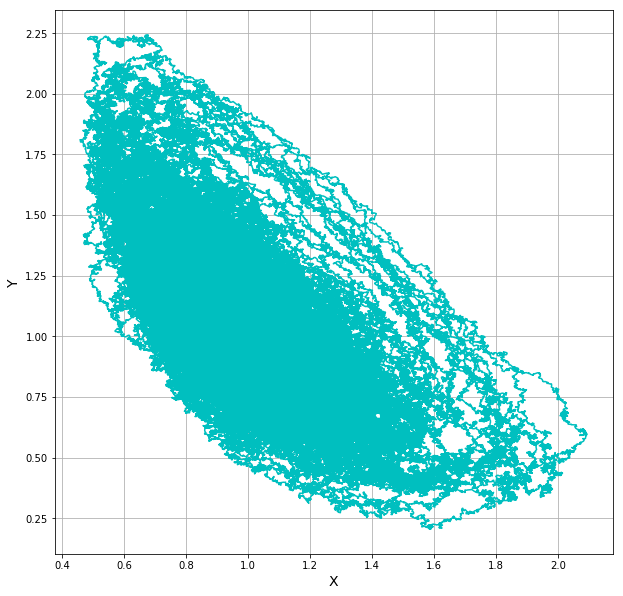

In [28]:
#Шум
step_buf = Step
p_buf = p
q_buf = q
p=1.4
q = 1
Step = 0.001
noise_lvl = 0.1
crv = noisy_curve(singular_point_x+0.001,singular_point_y+0.001,1000000)
plt.plot(crv[0],crv[1],c='c')
print("Singular point is: ["+str(singular_point_x)+", "+str(singular_point_y)+"].")
print("Expectance is "+str(expectancy(crv)))
print("Disperison is "+str(dispersion(crv)))

plt.grid()
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)

plt.show()
p = p_buf
q=q_buf
Step = step_buf


Singular point is: [1, 1].
Expectance is [0.9996798227781232, 1.0003559726670301]
Disperison is [1.017522854526719e-05, 1.015286103158044e-05]
Singular point is: [1, 1].
Expectance is [0.9996518137951216, 1.0004534870513895]
Disperison is [0.00012651392863075676, 0.00012812700133520182]
Singular point is: [1, 1].
Expectance is [0.99974853173962, 1.0007022769649234]
Disperison is [0.00041376087965458794, 0.00041686106445439807]
Singular point is: [1, 1].
Expectance is [1.0040109460811526, 0.9968821123756201]
Disperison is [0.0008477695070704948, 0.0008488823104345376]
Singular point is: [1, 1].
Expectance is [0.9925622855376148, 1.0091055790207275]
Disperison is [0.0014887567461033056, 0.0014896394469352007]
Singular point is: [1, 1].
Expectance is [0.9970392355530957, 1.0044915607690117]
Disperison is [0.0017657662395971845, 0.0017934002058590042]
Singular point is: [1, 1].
Expectance is [0.9979215989914233, 1.0047486704627067]
Disperison is [0.0027897482138943613, 0.002890734915763761

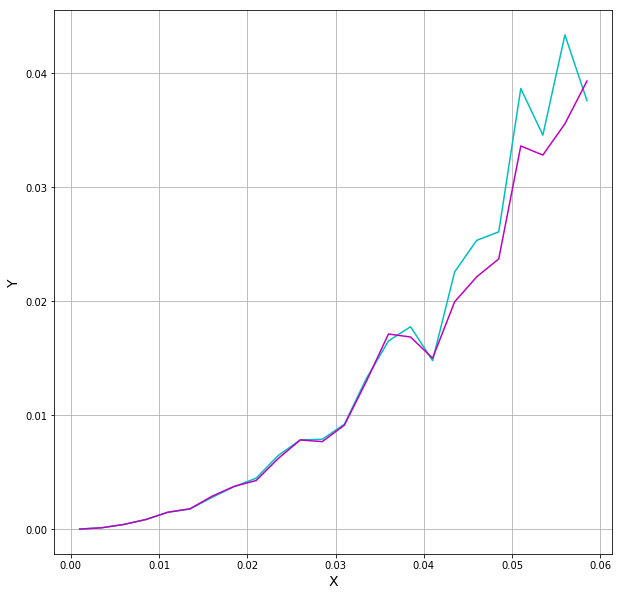

In [38]:
#Шум
step_buf = Step
p_buf = p
q=1
p=0.1
Step = 0.001
noise_lvl = 0.01
dis_X = list()
dis_Y = list()
parameter = list()
for i in range(0,24):
    noise_lvl = 0.001+i*0.0025
    crv = noisy_curve(singular_point_x,singular_point_y,4000000)
    disp = dispersion(crv)
    dis_X.append(disp[0])
    dis_Y.append(disp[1])
    parameter.append(noise_lvl)
    print("Singular point is: ["+str(singular_point_x)+", "+str(singular_point_y)+"].")
    print("Expectance is "+str(expectancy(crv)))
    print("Disperison is "+str(disp))
plt.plot(parameter,dis_X,c='c')
plt.plot(parameter,dis_Y,c='m')
plt.grid()
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.show()
p = p_buf
Step = step_buf


Singular point is: [1, 1].
Expectance is [0.9999509030682071, 1.0001099679241623]
Disperison is [3.1248508221716547e-06, 4.629418013002848e-06]
Singular point is: [1, 1].
Expectance is [0.9997955500742378, 1.0001641836867488]
Disperison is [0.00011637656774365372, 0.00016411962001797666]
Singular point is: [1, 1].
Expectance is [1.0010624261314944, 0.9991407034676587]
Disperison is [0.0004591309249298154, 0.0006680716983604273]
Singular point is: [1, 1].
Expectance is [1.0002418745369983, 1.0012398720660098]
Disperison is [0.000863613490729588, 0.001237412165607498]
Singular point is: [1, 1].
Expectance is [0.999704703590329, 1.0021795262841704]
Disperison is [0.0017063714324560477, 0.0024564096762109155]
Singular point is: [1, 1].
Expectance is [0.9951069971526143, 1.0084508099076501]
Disperison is [0.0024496280358901456, 0.00350798623691641]
Singular point is: [1, 1].
Expectance is [1.0022495060477945, 1.0008074777100948]
Disperison is [0.003431617072538034, 0.004639473824222684]
Sin

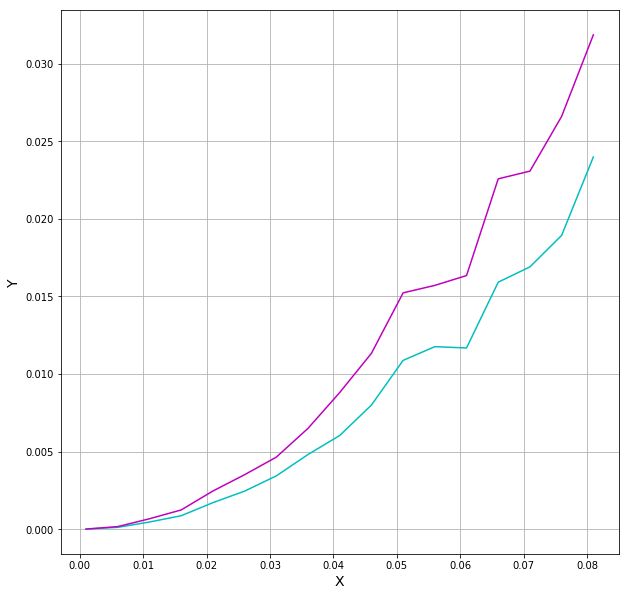

In [46]:
#Шум
step_buf = Step
p_buf = p
q=1
p=1
Step = 0.001
noise_lvl = 0.0025
dis_X = list()
dis_Y = list()
parameter = list()
for i in range(0,17):
    noise_lvl = 0.001+i*0.005
    crv = noisy_curve(singular_point_x,singular_point_y,1000000)
    disp = dispersion(crv)
    dis_X.append(disp[0])
    dis_Y.append(disp[1])
    parameter.append(noise_lvl)
    print("Singular point is: ["+str(singular_point_x)+", "+str(singular_point_y)+"].")
    print("Expectance is "+str(expectancy(crv)))
    print("Disperison is "+str(disp))
plt.plot(parameter,dis_X,c='c')
plt.plot(parameter,dis_Y,c='m')
plt.grid()
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.show()
p = p_buf
Step = step_buf


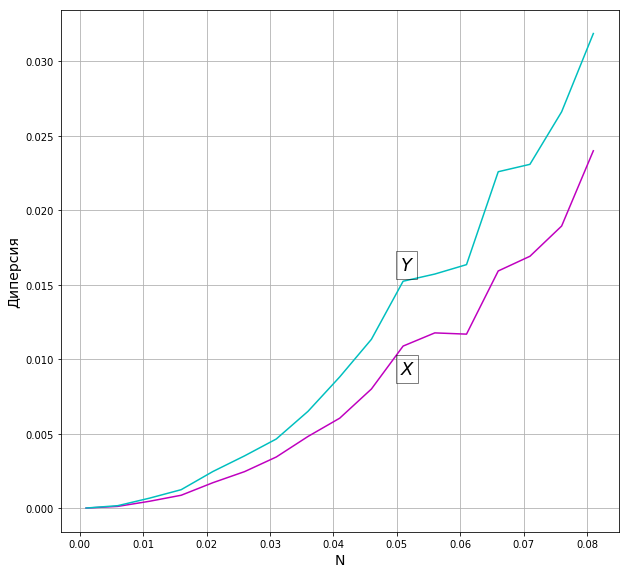

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.text(0.0506, 0.016, 'Y', style='italic',fontsize=18, bbox={'facecolor':'none', 'alpha':0.5, 'pad':5})
ax.text(0.0506, 0.009, 'X', style='italic',fontsize=18, bbox={'facecolor':'none', 'alpha':0.5, 'pad':5})
plt.plot(parameter,dis_X,c='m')
plt.plot(parameter,dis_Y,c='c')

plt.grid()
plt.xlabel('N',fontsize=14)
plt.ylabel('Диперсия',fontsize=14)

plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


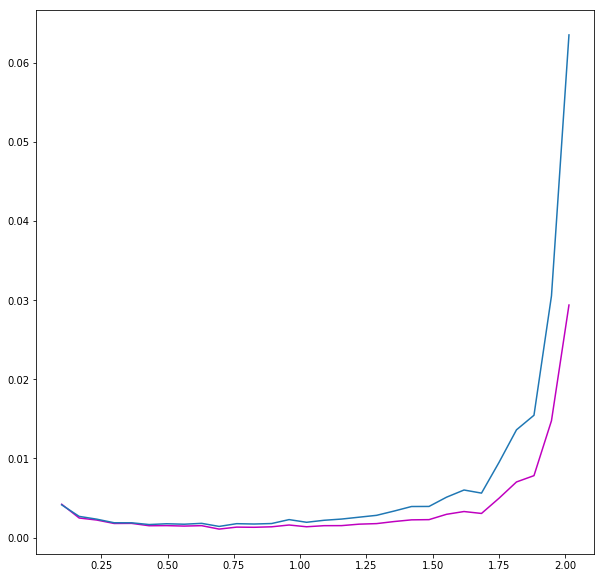

In [36]:
#по параметру
step_buf = Step
p_buf = p
p = 0.1
q=1
Step = 0.001
noise_lvl = 0.02
disX = list()
disY = list()
parameter = list()
for i in range(0,30):
    print(i)
    crv = noisy_curve(singular_point_x,singular_point_y,1000000)
    disp = dispersion(crv)
    disX.append(disp[0])
    disY.append(disp[1])
    parameter.append(p)
    p+= 0.066
plt.plot(parameter,disX,'m')
plt.plot(parameter,disY)
plt.show()
p = p_buf
Step = step_buf

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.text(1.8, 0.017, 'Y', style='italic',fontsize=18, bbox={'facecolor':'none', 'alpha':0.5, 'pad':5})
ax.text(1.8, 0.0025, 'X', style='italic',fontsize=18, bbox={'facecolor':'none', 'alpha':0.5, 'pad':5})
plt.plot(parameter,disX)
plt.plot(parameter,disY,'m')
plt.grid()
plt.xlabel('P',fontsize=14)
plt.ylabel('Диперсия',fontsize=14)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (17,) and (30,)